<a href="https://colab.research.google.com/github/pietroottana/finance-portfolio/blob/main/NFL_Predictor_ML_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss

In [71]:
df = pd.read_parquet("/content/games.parquet")

In [72]:
df

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,1999_01_MIN_ATL,1999,REG,1,1999-09-12,Sunday,None,MIN,17.0,ATL,...,NaN,00-0003761,00-0002876,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves,Gerry Austin,ATL00,Georgia Dome
1,1999_01_KC_CHI,1999,REG,1,1999-09-12,Sunday,None,KC,17.0,CHI,...,12.0,00-0006300,00-0010560,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron,Phil Luckett,CHI98,Soldier Field
2,1999_01_PIT_CLE,1999,REG,1,1999-09-12,Sunday,None,PIT,43.0,CLE,...,12.0,00-0015700,00-0004230,Kordell Stewart,Ty Detmer,Bill Cowher,Chris Palmer,Bob McElwee,CLE00,Cleveland Browns Stadium
3,1999_01_OAK_GB,1999,REG,1,1999-09-12,Sunday,None,OAK,24.0,GB,...,10.0,00-0005741,00-0005106,Rich Gannon,Brett Favre,Jon Gruden,Ray Rhodes,Tony Corrente,GNB00,Lambeau Field
4,1999_01_BUF_IND,1999,REG,1,1999-09-12,Sunday,None,BUF,14.0,IND,...,NaN,00-0005363,00-0010346,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,Ron Blum,IND99,RCA Dome
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7258,2025_18_DAL_NYG,2025,REG,18,2026-01-04,Sunday,13:00,DAL,NaN,NYG,...,NaN,None,None,None,None,Brian Schottenheimer,Brian Daboll,None,NYC01,MetLife Stadium
7259,2025_18_WAS_PHI,2025,REG,18,2026-01-04,Sunday,13:00,WAS,NaN,PHI,...,NaN,None,None,None,None,Dan Quinn,Nick Sirianni,None,PHI00,Lincoln Financial Field
7260,2025_18_BAL_PIT,2025,REG,18,2026-01-04,Sunday,13:00,BAL,NaN,PIT,...,NaN,None,None,None,None,John Harbaugh,Mike Tomlin,None,PIT00,Acrisure Stadium
7261,2025_18_SEA_SF,2025,REG,18,2026-01-04,Sunday,13:00,SEA,NaN,SF,...,NaN,None,None,None,None,Mike Macdonald,Kyle Shanahan,None,SFO01,Levi's Stadium


In [73]:
# Seasons for training model
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
df = df[df["season"].isin(years)].copy()

In [74]:
#Only played games
df = df[
    (df["game_type"] == "REG") &
    df["home_score"].notna() &
    df["away_score"].notna()
].copy()

In [75]:
# Create game_date and target home_win
df["game_date"] = pd.to_datetime(df["gameday"])
df = df.sort_values("game_date").reset_index(drop=True)
df["home_win"] = (df["home_score"] > df["away_score"]).astype(int)


In [76]:
df.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,game_date,home_win
0,2018_01_ATL_PHI,2018,REG,1,2018-09-06,Thursday,20:20,ATL,12.0,PHI,...,00-0029567,Matt Ryan,Nick Foles,Dan Quinn,Doug Pederson,John Hussey,PHI00,Lincoln Financial Field,2018-09-06,1
1,2018_01_CHI_GB,2018,REG,1,2018-09-09,Sunday,20:20,CHI,23.0,GB,...,00-0023459,Mitch Trubisky,Aaron Rodgers,Matt Nagy,Mike McCarthy,Carl Cheffers,GNB00,Lambeau Field,2018-09-09,1
2,2018_01_SEA_DEN,2018,REG,1,2018-09-09,Sunday,16:25,SEA,24.0,DEN,...,00-0028986,Russell Wilson,Case Keenum,Pete Carroll,Vance Joseph,Brad Allen,DEN00,Sports Authority Field at Mile High,2018-09-09,1
3,2018_01_WAS_ARI,2018,REG,1,2018-09-09,Sunday,16:25,WAS,24.0,ARI,...,00-0027854,Alex Smith,Sam Bradford,Jay Gruden,Steve Wilks,Walt Coleman,PHO00,State Farm Stadium,2018-09-09,0
4,2018_01_KC_LAC,2018,REG,1,2018-09-09,Sunday,16:05,KC,38.0,LAC,...,00-0022942,Patrick Mahomes,Philip Rivers,Andy Reid,Anthony Lynn,Clete Blakeman,LAX97,StubHub Center,2018-09-09,0


In [77]:
# Home team POV
home_df = df[[
    "game_id", "game_date", "season", "week",
    "home_team", "away_team",
    "home_score", "away_score",
]].copy()

home_df = home_df.rename(columns={
    "home_team": "team",
    "away_team": "opponent",
    "home_score": "points_scored",
    "away_score": "points_allowed",
})
home_df["is_home"] = 1

In [78]:
# Away team POV
away_df = df[[
    "game_id", "game_date", "season", "week",
    "away_team", "home_team",
    "away_score", "home_score",
]].copy()

away_df = away_df.rename(columns={
    "away_team": "team",
    "home_team": "opponent",
    "away_score": "points_scored",
    "home_score": "points_allowed",
})
away_df["is_home"] = 0


In [79]:
team_games = pd.concat([home_df, away_df], ignore_index=True)
team_games = team_games.sort_values(["team", "game_date"]).reset_index(drop=True)

In [80]:
def add_rolling_features(df, windows=[3, 5]):
    df = df.copy()

    # Binary result in that game
    df["win"] = (df["points_scored"] > df["points_allowed"]).astype(int)

    # Points Margin (scored - allowed)
    df["point_diff"] = df["points_scored"] - df["points_allowed"]

    # Margin from last game
    df["point_diff_last_1"] = (
        df.sort_values("game_date")
          .groupby("team")["point_diff"]
          .shift(1)
    )

    # Rest days from last game
    df["rest_days"] = (
        df.sort_values("game_date")
          .groupby("team")["game_date"]
          .diff()
          .dt.days
    )

    for w in windows:
        # Avg points scored in last w games
        df[f"pts_scored_avg_{w}"] = (
            df.groupby("team")["points_scored"]
              .transform(lambda x: x.shift(1).rolling(w).mean())
        )

        # Avg points allowed in last w games
        df[f"pts_allowed_avg_{w}"] = (
            df.groupby("team")["points_allowed"]
              .transform(lambda x: x.shift(1).rolling(w).mean())
        )

        # Win rate on last w games
        df[f"win_rate_{w}"] = (
            df.groupby("team")["win"]
              .transform(lambda x: x.shift(1).rolling(w).mean())
        )

        # Point margin last w games
        df[f"point_diff_avg_{w}"] = (
            df.groupby("team")["point_diff"]
              .transform(lambda x: x.shift(1).rolling(w).mean())
        )

    return df

In [81]:
rolling_features = [
    "pts_scored_avg_3",
    "pts_allowed_avg_3",
    "win_rate_3",
    "point_diff_avg_3",
    "pts_scored_avg_5",
    "pts_allowed_avg_5",
    "win_rate_5",
    "point_diff_avg_5",
]

extra_features = [
    "point_diff_last_1",
    "rest_days",
]

team_features = rolling_features + extra_features

team_features

['pts_scored_avg_3',
 'pts_allowed_avg_3',
 'win_rate_3',
 'point_diff_avg_3',
 'pts_scored_avg_5',
 'pts_allowed_avg_5',
 'win_rate_5',
 'point_diff_avg_5',
 'point_diff_last_1',
 'rest_days']

In [82]:
team_games = add_rolling_features(team_games)
team_games_clean = team_games.dropna().reset_index(drop=True)
team_games_clean.head()

,game_id,game_date,season,week,team,opponent,points_scored,points_allowed,is_home,win,...,point_diff_last_1,rest_days,pts_scored_avg_3,pts_allowed_avg_3,win_rate_3,point_diff_avg_3,pts_scored_avg_5,pts_allowed_avg_5,win_rate_5,point_diff_avg_5
0,2018_06_ARI_MIN,2018-10-14,2018,6,ARI,MIN,17.0,27.0,0,0,...,10.0,7.0,19.666667,18.000000,0.333333,1.666667,13.0,22.4,0.2,-9.4
1,2018_07_DEN_ARI,2018-10-18,2018,7,ARI,DEN,10.0,45.0,1,0,...,-10.0,4.0,20.666667,21.666667,0.333333,-1.000000,15.2,23.0,0.2,-7.8
2,2018_08_SF_ARI,2018-10-28,2018,8,ARI,SF,18.0,15.0,1,1,...,-35.0,10.0,18.333333,30.000000,0.333333,-11.666667,17.2,25.2,0.2,-8.0
3,2018_10_ARI_KC,2018-11-11,2018,10,ARI,KC,14.0,26.0,0,0,...,3.0,14.0,15.000000,29.000000,0.333333,-14.000000,18.0,25.0,0.4,-7.0
4,2018_11_OAK_ARI,2018-11-18,2018,11,ARI,OAK,21.0,23.0,1,0,...,-12.0,7.0,14.000000,28.666667,0.333333,-14.666667,17.4,26.2,0.4,-8.8


In [83]:
base_cols = ["game_id", "team"] + team_features

home_team_feats = (
    team_games_clean[team_games_clean["is_home"] == 1][base_cols]
    .rename(columns={col: f"{col}_home" for col in team_features})
)

away_team_feats = (
    team_games_clean[team_games_clean["is_home"] == 0][base_cols]
    .rename(columns={col: f"{col}_away" for col in team_features})
)

matchups = df.copy()

matchups = matchups.merge(
    home_team_feats,
    left_on=["game_id", "home_team"],
    right_on=["game_id", "team"],
    how="left"
)

matchups = matchups.merge(
    away_team_feats,
    left_on=["game_id", "away_team"],
    right_on=["game_id", "team"],
    how="left",
    suffixes=("_home_team_key", "_away_team_key"),
)

matchups = matchups.drop(columns=["team_home_team_key", "team_away_team_key"])

In [84]:
all_feat_home = [f"{f}_home" for f in team_features]
all_feat_away = [f"{f}_away" for f in team_features]

matchups_clean = matchups.dropna(subset=all_feat_home + all_feat_away).reset_index(drop=True)

for f in team_features:
    matchups_clean[f"{f}_diff"] = matchups_clean[f"{f}_home"] - matchups_clean[f"{f}_away"]

feature_cols = [f"{f}_diff" for f in team_features]
len(matchups_clean), feature_cols


(1769,
 ['pts_scored_avg_3_diff',
  'pts_allowed_avg_3_diff',
  'win_rate_3_diff',
  'point_diff_avg_3_diff',
  'pts_scored_avg_5_diff',
  'pts_allowed_avg_5_diff',
  'win_rate_5_diff',
  'point_diff_avg_5_diff',
  'point_diff_last_1_diff',
  'rest_days_diff'])

In [85]:
for f in rolling_features:
    matchups_clean[f"{f}_diff"] = (
        matchups_clean[f"{f}_home"] - matchups_clean[f"{f}_away"]
    )

In [86]:
matchups_clean.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,pts_scored_avg_3_diff,pts_allowed_avg_3_diff,win_rate_3_diff,point_diff_avg_3_diff,pts_scored_avg_5_diff,pts_allowed_avg_5_diff,win_rate_5_diff,point_diff_avg_5_diff,point_diff_last_1_diff,rest_days_diff
0,2018_06_PHI_NYG,2018,REG,6,2018-10-11,Thursday,20:20,PHI,34.0,NYG,...,4.000000,7.666667,0.000000,-3.666667,0.2,4.8,-0.2,-4.6,0.0,0.0
1,2018_06_LA_DEN,2018,REG,6,2018-10-14,Sunday,16:05,LA,23.0,DEN,...,-17.666667,1.000000,-1.000000,-18.666667,-14.6,6.6,-0.6,-21.2,-20.0,0.0
2,2018_06_ARI_MIN,2018,REG,6,2018-10-14,Sunday,13:00,ARI,17.0,MIN,...,0.333333,10.666667,0.000000,-10.333333,9.6,3.8,0.2,5.8,-8.0,0.0
3,2018_06_BAL_TEN,2018,REG,6,2018-10-14,Sunday,16:25,BAL,21.0,TEN,...,-5.000000,0.666667,0.000000,-5.666667,-9.0,1.8,0.0,-10.8,2.0,0.0
4,2018_06_KC_NE,2018,REG,6,2018-10-14,Sunday,20:20,KC,40.0,NE,...,-3.000000,-2.333333,-0.333333,-0.666667,-8.4,-4.2,-0.4,-4.2,-2.0,3.0


In [87]:
feature_cols = [f"{f}_diff" for f in rolling_features]
feature_cols

['pts_scored_avg_3_diff',
 'pts_allowed_avg_3_diff',
 'win_rate_3_diff',
 'point_diff_avg_3_diff',
 'pts_scored_avg_5_diff',
 'pts_allowed_avg_5_diff',
 'win_rate_5_diff',
 'point_diff_avg_5_diff']

In [88]:
X = matchups_clean[feature_cols].copy()
y = matchups_clean["home_win"].astype(int)

X.head(), y.head()

(   pts_scored_avg_3_diff  pts_allowed_avg_3_diff  win_rate_3_diff  \
 0               4.000000                7.666667         0.000000   
 1             -17.666667                1.000000        -1.000000   
 2               0.333333               10.666667         0.000000   
 3              -5.000000                0.666667         0.000000   
 4              -3.000000               -2.333333        -0.333333   
 
    point_diff_avg_3_diff  pts_scored_avg_5_diff  pts_allowed_avg_5_diff  \
 0              -3.666667                    0.2                     4.8   
 1             -18.666667                  -14.6                     6.6   
 2             -10.333333                    9.6                     3.8   
 3              -5.666667                   -9.0                     1.8   
 4              -0.666667                   -8.4                    -4.2   
 
    win_rate_5_diff  point_diff_avg_5_diff  
 0             -0.2                   -4.6  
 1             -0.6           

In [89]:
print(len(X), len(y))

1769 1769


In [90]:
#DATASET READY
#NOW TRAIN MODEL

In [91]:
train = matchups_clean[matchups_clean["season"] <= 2023].copy()
test  = matchups_clean[matchups_clean["season"] == 2024].copy()

X_train = train[feature_cols]
y_train = train["home_win"].astype(int)

X_test = test[feature_cols]
y_test = test["home_win"].astype(int)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 1497
Test size: 272


In [92]:
# Model: scaler + logistic regression
model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500))
])

# Training
model.fit(X_train, y_train)

# 2024 test
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]   # P(home team win)

acc = accuracy_score(y_test, y_pred)
ll  = log_loss(y_test, y_prob)

print(f"Accuracy 2024: {acc:.3f}")
print(f"Log-loss 2024: {ll:.3f}")

Accuracy 2024: 0.647
Log-loss 2024: 0.649


In [93]:
latest_team_state = (
    team_games_clean
    .sort_values("game_date")
    .groupby("team")
    .tail(1)[["team"] + team_features]
    .reset_index(drop=True)
)

In [94]:
team_games_clean

,game_id,game_date,season,week,team,opponent,points_scored,points_allowed,is_home,win,...,point_diff_last_1,rest_days,pts_scored_avg_3,pts_allowed_avg_3,win_rate_3,point_diff_avg_3,pts_scored_avg_5,pts_allowed_avg_5,win_rate_5,point_diff_avg_5
0,2018_06_ARI_MIN,2018-10-14,2018,6,ARI,MIN,17.0,27.0,0,0,...,10.0,7.0,19.666667,18.000000,0.333333,1.666667,13.0,22.4,0.2,-9.4
1,2018_07_DEN_ARI,2018-10-18,2018,7,ARI,DEN,10.0,45.0,1,0,...,-10.0,4.0,20.666667,21.666667,0.333333,-1.000000,15.2,23.0,0.2,-7.8
2,2018_08_SF_ARI,2018-10-28,2018,8,ARI,SF,18.0,15.0,1,1,...,-35.0,10.0,18.333333,30.000000,0.333333,-11.666667,17.2,25.2,0.2,-8.0
3,2018_10_ARI_KC,2018-11-11,2018,10,ARI,KC,14.0,26.0,0,0,...,3.0,14.0,15.000000,29.000000,0.333333,-14.000000,18.0,25.0,0.4,-7.0
4,2018_11_OAK_ARI,2018-11-18,2018,11,ARI,OAK,21.0,23.0,1,0,...,-12.0,7.0,14.000000,28.666667,0.333333,-14.666667,17.4,26.2,0.4,-8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540,2024_13_TEN_WAS,2024-12-01,2024,13,WAS,TEN,42.0,19.0,1,1,...,-8.0,7.0,23.666667,29.333333,0.000000,-5.666667,23.2,25.0,0.4,-1.8
3541,2024_15_WAS_NO,2024-12-15,2024,15,WAS,NO,20.0,19.0,0,1,...,23.0,14.0,28.666667,26.333333,0.333333,2.333333,28.0,25.8,0.4,2.2
3542,2024_16_PHI_WAS,2024-12-22,2024,16,WAS,PHI,36.0,33.0,1,1,...,1.0,7.0,29.333333,24.000000,0.666667,5.333333,26.6,25.2,0.4,1.4
3543,2024_17_ATL_WAS,2024-12-29,2024,17,WAS,ATL,30.0,24.0,1,1,...,3.0,7.0,32.666667,23.666667,1.000000,9.000000,28.4,26.2,0.6,2.2


In [95]:
def predict_matchup(home_team, away_team, model, latest_team_state, team_features, feature_cols):
    home_row = latest_team_state[latest_team_state["team"] == home_team]
    away_row = latest_team_state[latest_team_state["team"] == away_team]

    if home_row.empty or away_row.empty:
        raise ValueError("One of the teams is not in the team features.")

    data = {}
    for f in team_features:
        data[f + "_diff"] = float(home_row[f].values[0] - away_row[f].values[0])

    X = pd.DataFrame([data])
    X = X[feature_cols]

    prob_home = model.predict_proba(X)[0][1]
    prob_away = 1 - prob_home

    return prob_home, prob_away


In [96]:
prob_home, prob_away = predict_matchup(
    "KC", "BUF",
    model,
    latest_team_state,
    team_features,
    feature_cols
)

print("Prob home:", prob_home)
print("Prob away:", prob_away)


Prob home: 0.40446286259968744
Prob away: 0.5955371374003126


## **Model Accuracy Checks**

In [97]:
accuracy_score(y_test, y_pred)

0.6470588235294118

In [98]:
log_loss(y_test, y_prob)

0.6493389921714355

In [99]:
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, y_prob)
print("Brier score:", brier)

Brier score: 0.2277483065910666


In [100]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)


AUC: 0.6834102633722509


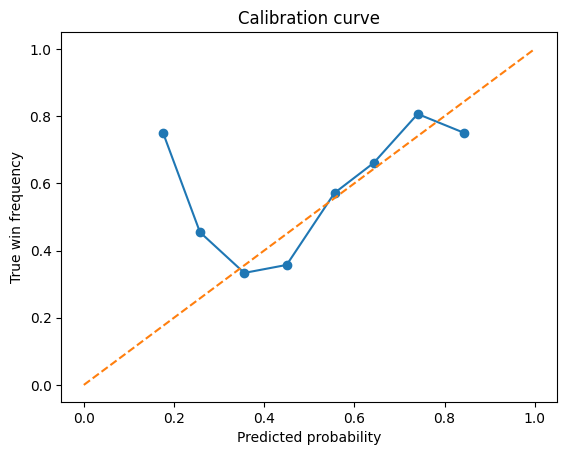

In [101]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("Predicted probability")
plt.ylabel("True win frequency")
plt.title("Calibration curve")
plt.show()

In [102]:
import pandas as pd

df_eval = pd.DataFrame({"prob": y_prob, "actual": y_test})
df_eval["bin"] = pd.cut(df_eval["prob"], bins=[0,0.2,0.4,0.6,0.8,1], include_lowest=True)

df_eval.groupby("bin").agg(
    count=("actual", "size"),
    predicted_prob=("prob", "mean"),
    actual_win_rate=("actual", "mean")
)


/tmp/ipython-input-1025584085.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_eval.groupby("bin").agg(


,count,predicted_prob,actual_win_rate
bin,,,
"(-0.001, 0.2]",4,0.175800,0.750000
"(0.2, 0.4]",47,0.332858,0.361702
"(0.4, 0.6]",126,0.497039,0.452381
"(0.6, 0.8]",87,0.677574,0.712644
"(0.8, 1.0]",8,0.843698,0.750000
